In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("penn-endurance.csv")

In [3]:
raw_data.head()

,cycle_start_us,engine_rpm,secondary_rpm,filtered_engine_rpm,filtered_secondary_rpm,target_rpm,velocity_command,velocity_estimate,position_estimate,bus_voltage,bus_current,iq_measured,iq_setpoint,inbound_limit_switch,outbound_limit_switch,engage_limit_switch,throttle,brake,d_throttle
0,15171700.0,6.2939,2.9128,0.0000,0.0228,2000.0,-69.1839,0.0,-0.0603,54.1849,-0.0001,0.0343,0.0,1,1,1,0.0,0.0,0.0
1,15181700.0,6.2939,2.9128,1.5435,0.1079,2000.0,-80.0000,0.0,-0.0603,54.1782,0.0001,-0.0104,0.0,1,1,1,0.0,0.0,0.0
2,15191700.0,6.2939,2.9128,3.8735,0.2608,2000.0,-80.0000,0.0,-0.0603,54.1849,0.0000,0.0617,0.0,1,1,1,0.0,0.0,0.0
3,15201700.0,6.2939,2.9128,5.0606,0.4608,2000.0,-79.2529,0.0,-0.0603,54.1883,0.0001,-0.0346,0.0,1,1,1,0.0,0.0,0.0
4,15211700.0,6.2939,2.9128,5.6655,0.6908,2000.0,-73.4722,0.0,-0.0603,54.1849,-0.0001,0.0655,0.0,1,1,1,0.0,0.0,0.0


# Data Cleaning
Before processing and looking at the data, we will have to clean it. Below are some problems and goals
- The time base overflows (due to storing microseconds)
- Convert microseconds to seconds for interpretability

In [4]:
adjustment = 0
max_seen = 0
new_values = []
 
for i in range(len(raw_data)):
    if i > 0 and raw_data['cycle_start_us'][i] < raw_data['cycle_start_us'][i-1]:
        # Loop detected, add the last max_seen value to adjustment
        adjustment += max_seen
        max_seen = 0  # Reset max_seen for the new cycle
    max_seen = max(max_seen, raw_data['cycle_start_us'][i])
    new_values.append(raw_data['cycle_start_us'][i] + adjustment)
 
raw_data['cycle_start_us'] = new_values

In [5]:
raw_data['seconds'] = raw_data["cycle_start_us"]/1e6

In [6]:
raw_data.head()

,cycle_start_us,engine_rpm,secondary_rpm,filtered_engine_rpm,filtered_secondary_rpm,target_rpm,velocity_command,velocity_estimate,position_estimate,bus_voltage,bus_current,iq_measured,iq_setpoint,inbound_limit_switch,outbound_limit_switch,engage_limit_switch,throttle,brake,d_throttle,seconds
0,15171700.0,6.2939,2.9128,0.0000,0.0228,2000.0,-69.1839,0.0,-0.0603,54.1849,-0.0001,0.0343,0.0,1,1,1,0.0,0.0,0.0,15.1717
1,15181700.0,6.2939,2.9128,1.5435,0.1079,2000.0,-80.0000,0.0,-0.0603,54.1782,0.0001,-0.0104,0.0,1,1,1,0.0,0.0,0.0,15.1817
2,15191700.0,6.2939,2.9128,3.8735,0.2608,2000.0,-80.0000,0.0,-0.0603,54.1849,0.0000,0.0617,0.0,1,1,1,0.0,0.0,0.0,15.1917
3,15201700.0,6.2939,2.9128,5.0606,0.4608,2000.0,-79.2529,0.0,-0.0603,54.1883,0.0001,-0.0346,0.0,1,1,1,0.0,0.0,0.0,15.2017
4,15211700.0,6.2939,2.9128,5.6655,0.6908,2000.0,-73.4722,0.0,-0.0603,54.1849,-0.0001,0.0655,0.0,1,1,1,0.0,0.0,0.0,15.2117


As expected, the seconds column increments by 0.01, which corresponds to our 10ms controls cycle.

# Data Exploration

In [7]:
df = raw_data

# Electrical Power Analysis

In this section, we explore the current data (bus_current) as well as the voltage data (bus_voltage) to gain insight into the power usage of the actuator. This section will provide statistics about power consumption (helping us justify the power of the motor), voltage sag (shows the health and capacity of the battery), and current draw (provides information about torque and allows us to spec the right size battery).

- Bus Current Consumption Over Time
- Current Consumption Distribution
    - What distribution does the current consumption roughly follow, and what current do we need to support to capture 95% of current consumption cases?
- Bus Voltage Over Time
- Total Current Consumption Over Endurance
- Total Voltage Sag Over Endurance
- Electrical Power Consumption Over Time
- Total Electrical Power Consumption (Watt Hours)


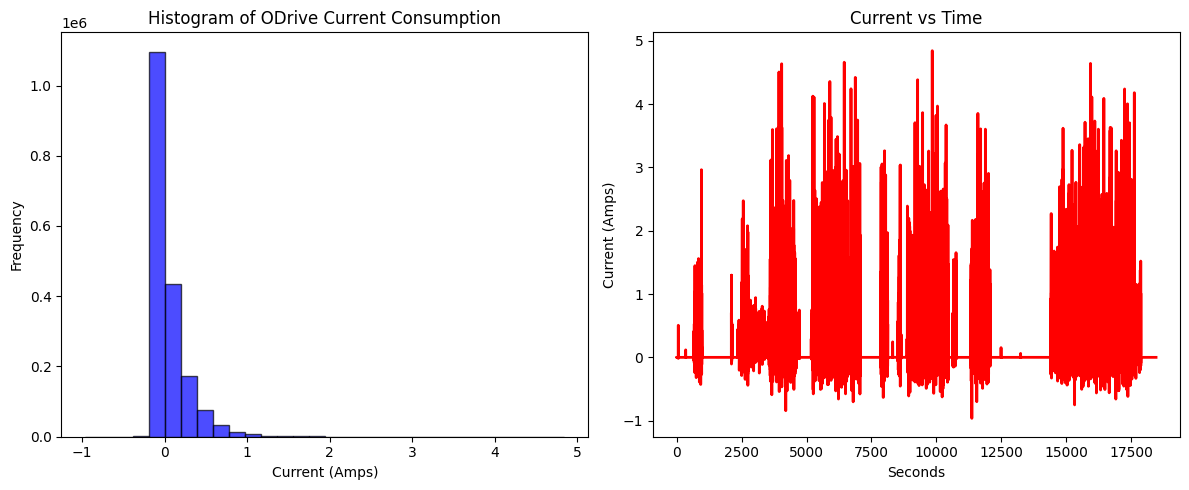

Total Current Consumption (Amp-Hours): 0.47794490548895047
Max Current Consumption (Amps): 4.8413


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram of Current Consumption
axes[0].hist(df['bus_current'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of ODrive Current Consumption')
axes[0].set_xlabel('Current (Amps)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['bus_current'], color='red', linewidth=2)
axes[1].set_title('Current vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Current (Amps)')

# Adjust layout
plt.tight_layout()
plt.show()

#Trapezoidal Integral of Current
print(f"Total Current Consumption (Amp-Hours): {np.trapezoid(df['bus_current'], x=(df['seconds']/3600))}")
print(f"Max Current Consumption (Amps): {df['bus_current'].max()}")

From the current consumption histogram and the max, we can see that we don't pull nearly as much current as we intially thought. We pull a max of around 5 amps, and it seems that we mostly consume under an amp of current at normal operation.

The total current consumption is also very suprising. A consumption of only 0.5 amps indicates that our battery (11Ah) is almost **22 times oversized**!

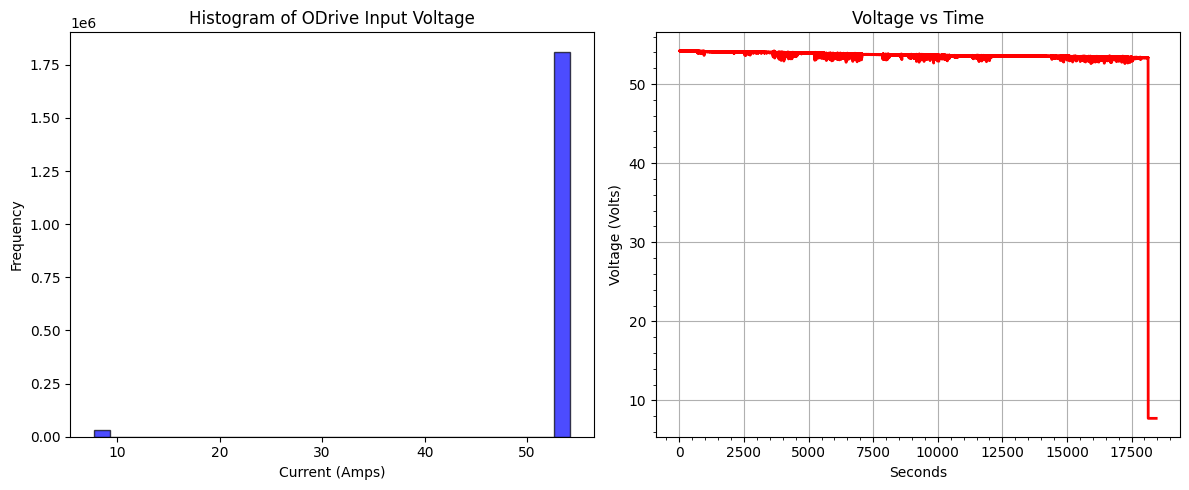

The max voltage was 54.195V and the min voltage was 52.577V
The total voltage sag was 1.618V


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram of Voltage
axes[0].hist(df['bus_voltage'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of ODrive Input Voltage')
axes[0].set_xlabel('Current (Amps)')
axes[0].set_ylabel('Frequency')

# Line Plot of Voltage over Endurance
axes[1].plot(df['seconds'], df['bus_voltage'], color='red', linewidth=2)
axes[1].set_title('Voltage vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Voltage (Volts)')
axes[1].grid()
axes[1].minorticks_on()

# Adjust layout
plt.tight_layout()
plt.show()

#Find the max and min voltage, as well as the voltage sag
maxV = df.loc[df['engine_rpm'] > 1800, 'bus_voltage'].max()
minV = df.loc[df['engine_rpm'] > 1800, 'bus_voltage'].min()
print(f"The max voltage was {maxV}V and the min voltage was {minV}V")
print(f"The total voltage sag was {maxV-minV:.03f}V")

While there's not too much to glean from this analysis, it's important to note the voltage sagging about 1-2V during normal operation (as shown by the line graph). This could be indicative of sudden loads drawing ammounts larger than the battery can support, or simply be a symptom of the Odrive not measuring voltages correctly during regen braking. Either way, **a large capacitor to supplement the capacitor bank on the Odrive seems to be a good idea**.

In [10]:
df['actuator_power'] = df['bus_current'] * df['bus_voltage']

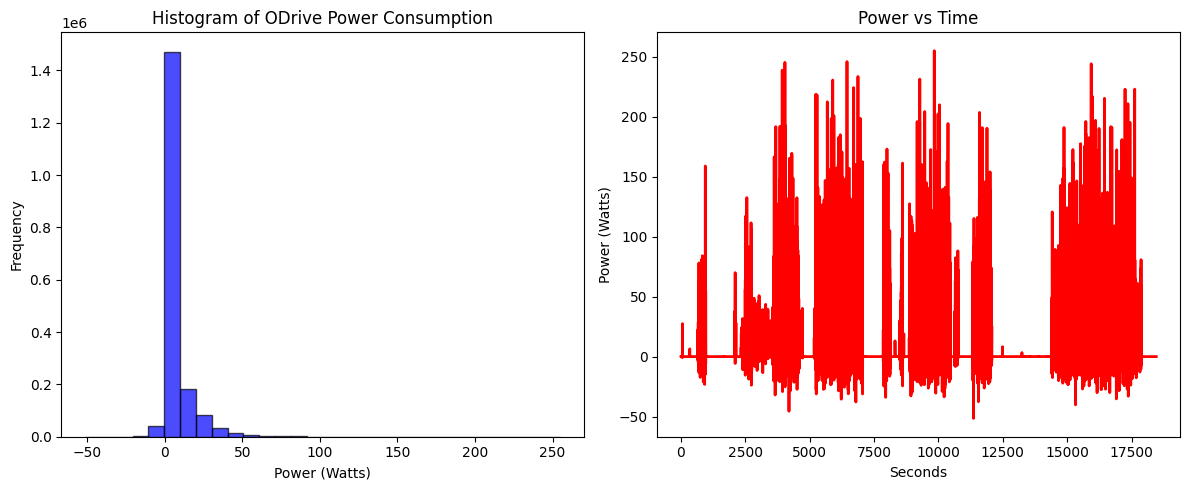

Total Power Consumption (Watt-Hours): 25.59039252998716
Max Power Consumption (Watts): 254.88331001000003


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram of Current Consumption
axes[0].hist(df['actuator_power'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of ODrive Power Consumption')
axes[0].set_xlabel('Power (Watts)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['actuator_power'], color='red', linewidth=2)
axes[1].set_title('Power vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Power (Watts)')

# Adjust layout
plt.tight_layout()
plt.show()

#Trapezoidal Integral of Power
print(f"Total Power Consumption (Watt-Hours): {np.trapezoid(df['actuator_power'], x=(df['seconds']/3600))}")
print(f"Max Power Consumption (Watts): {df['actuator_power'].max()}")

Surprisingly, the actuator's power consumption is MUCH less than previously anticipated. This indicates that **our power system is seriously overkill for our application**. Furthermore, it suggests that a smaller motor would be sufficient. This could significantly improve the packaging of the ECVT, as well as reduce weight.

One large caveat if we do decide to reduce the size of the motor is to keep in mind that simply looking at the power doesn't tell the full story. The motor might have to support high torque and high speed at different times, which would show a low power, but still require the large motor for performance. Further testing is required.

# Controls Performance Analysis

In this section, we want to gain insight into the software side of the car’s performance. This section will provide insight into the efficiency of the code, potential bottlenecks for controls, and hopefully give us direction for future controls improvements.

- Velocity Command vs Time
- Engine RPM vs Time
- Tracking Error
- Filtered Engine RPM vs Engine RPM
    - Correlation, data loss
- Target RPM vs Engine RPM and Difference
    - Perspective on tracking performance
- Cycle Tick Consistency
    - Consistency of controls system evaluation.
- Velocity Command Vs. Velocity Estimate.
    - Difference between the two.
    - Provides insight into how well the inner motor control loop is tracking our commands. (filtered and unfiltered)
- Position Estimate Over Time

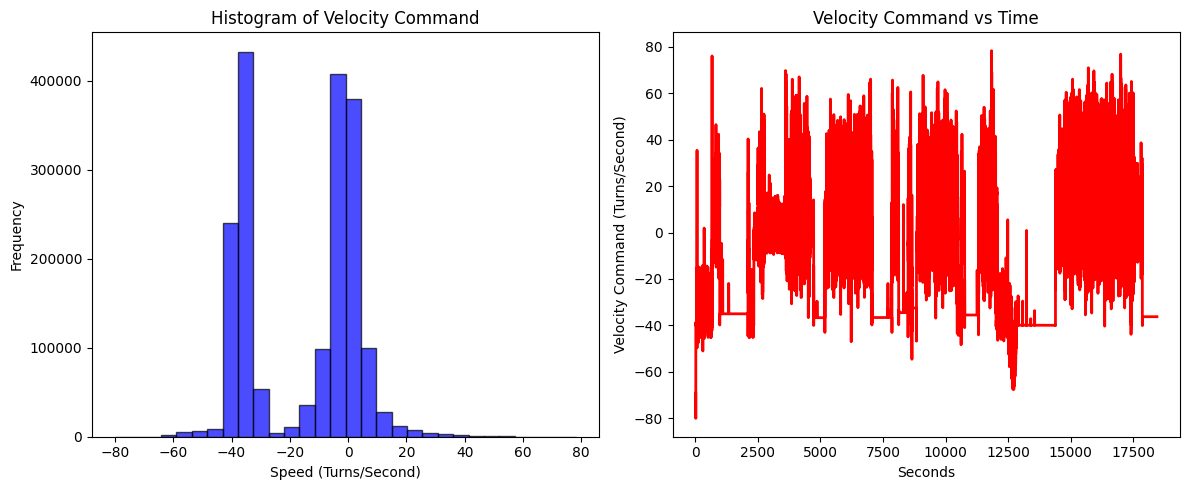

Max Actuator Velocity: 78.2628


In [12]:
#Velocity Command vs Time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram of Current Consumption
axes[0].hist(df['velocity_command'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Velocity Command')
axes[0].set_xlabel('Speed (Turns/Second)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['velocity_command'], color='red', linewidth=2)
axes[1].set_title('Velocity Command vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Velocity Command (Turns/Second)')

# Adjust layout
plt.tight_layout()
plt.show()


print(f"Max Actuator Velocity: {df['velocity_command'].max()}")

While there's not much here out of the ordinary, it's important to note that the distribution of the actuator velocity is bimodal. This poses an interesting question: are there two regimes of performance to the actuator? Does this indicate we should be spending more time optimizing for disturbance rejection? Or is this indication that the system is performing as intended and there's really no problem... Further investigation is needed.

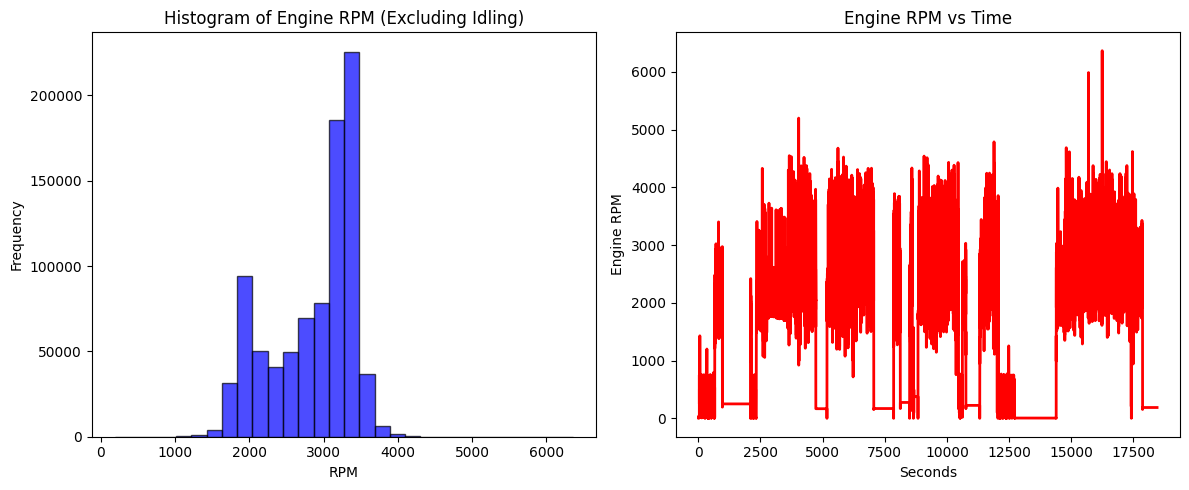

Mean Engine RPM (Excluding Car Idling): 2870.3735775483924


In [13]:
#Velocity Command vs Time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns


#Condition the histogram on when the car is NOT fully outbound (NOT clutched)
axes[0].hist(df.loc[(df['outbound_limit_switch'] == 0), 'engine_rpm'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Engine RPM (Excluding Idling)')
axes[0].set_xlabel('RPM')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['engine_rpm'], color='red', linewidth=2)
axes[1].set_title('Engine RPM vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Engine RPM')

# Adjust layout
plt.tight_layout()
plt.show()

print(f"Mean Engine RPM (Excluding Car Idling): {df.loc[df['outbound_limit_switch'] == 0, 'engine_rpm'].mean()}")

The engine RPM histogram tells an interesting story. It is also bimodal, showing that the largest utilization is around 2000 rpm and 3500 rpm. The peak at 2000 RPM makes sense, as in low speed corners, our controller will target 2000 RPM. 

It's particularly interesting that the second peak is at 3500 RPM. This suggests that the car *wants* to go faster, but is limited by either the controller or the physical limits of the system.

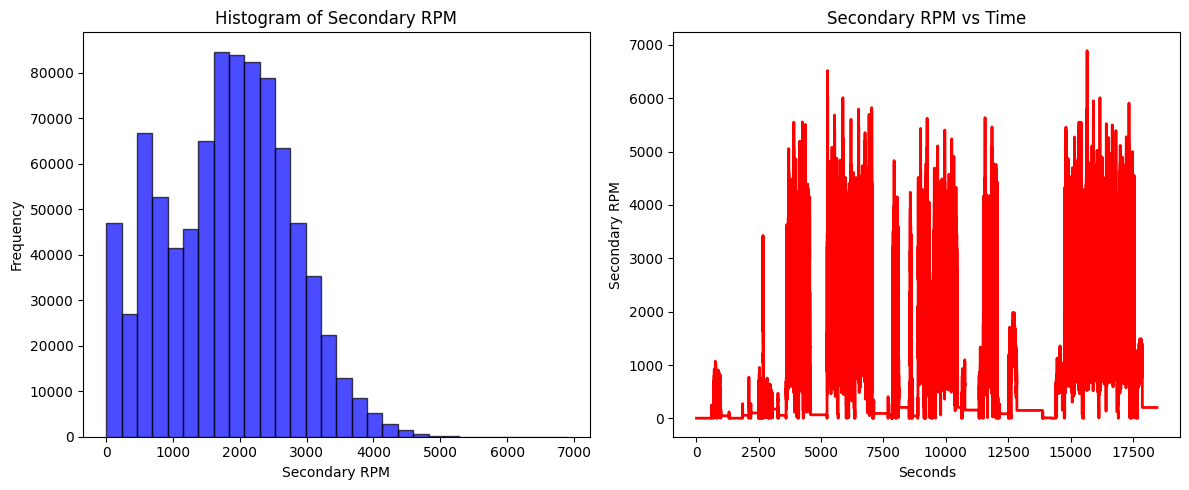

In [28]:
#Secondary RPM
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

#Condition the histogram on when the actuator has no velocity command
axes[0].hist(df.loc[(df['outbound_limit_switch'] != 1),'secondary_rpm'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Secondary RPM')
axes[0].set_xlabel('Secondary RPM')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['secondary_rpm'], color='red', linewidth=2)
axes[1].set_title('Secondary RPM vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Secondary RPM')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
df['tracking_error'] = df['engine_rpm'] - df['target_rpm']

In [15]:
print("-----------------Tracking Error Summary Statistics-----------------")
df.loc[(abs(df['velocity_command']) > 1), 'tracking_error'].describe()

-----------------Tracking Error Summary Statistics-----------------


count    1.657114e+06
mean    -9.067122e+02
std      8.967921e+02
min     -3.251897e+03
25%     -1.812505e+03
50%     -4.999253e+02
75%     -8.844150e+01
max      3.064022e+03
Name: tracking_error, dtype: float64

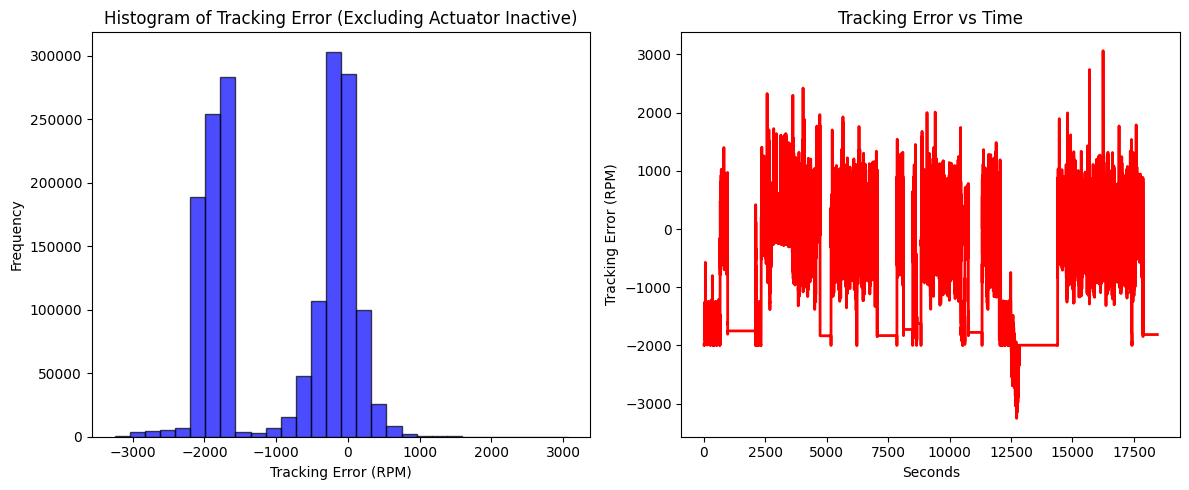

In [16]:
#Tracking Error vs Time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

#Condition the histogram on when the actuator has no velocity command
axes[0].hist(df.loc[(abs(df['velocity_command']) > 1), 'tracking_error'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Tracking Error (Excluding Actuator Inactive)')
axes[0].set_xlabel('Tracking Error (RPM)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['tracking_error'], color='red', linewidth=2)
axes[1].set_title('Tracking Error vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Tracking Error (RPM)')

# Adjust layout
plt.tight_layout()
plt.show()

Note that tracking error is defined as engine RPM - target RPM. The first peak of this bimodal distribution occurs at -2000 RPM. This indicates that our tracking performance when accelerating is very poor. This makes sense, as the car was often described as "laggy". **Eliminating this lag should be a primary concern for improving the controls system this year**. The other peak is exactly what we want, a tracking error centered around 0, although the spread of the tracking error could be improved.

The larger negative values could also be due to the driver letting off the gas while coasting. The car is moving fast, keeping the target RPM high, but the engine is slowing down faster than the transmission can compensate for. 

The mean tracking error (not including values where the actuator doesn't move) is -907 RPM. That's pretty atrocious.

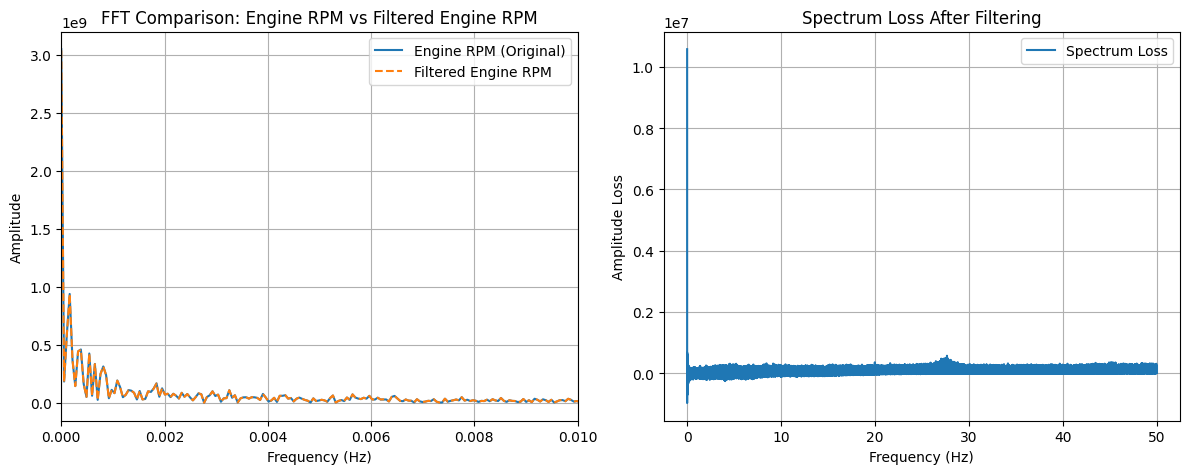

Percentage of Spectrum Lost: 0.70%
Correlation Between Filtered and Unfiltered Engine RPM: 0.9976478889145836


In [17]:
#Filtered Engine RPM vs Engine RPM
fs = 1/0.01

def compute_fft(signal, fs):
    n = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(n, 1 / fs)
    return fft_freqs[:n // 2], np.abs(fft_vals[:n // 2])  # Return positive frequencies

# Compute FFT for both signals
fft_freqs, fft_engine_rpm = compute_fft(df['engine_rpm'], fs)
_, fft_filtered_engine_rpm = compute_fft(df['filtered_engine_rpm'], fs)

#Tracking Error vs Time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns


# Plot both signals

axes[0].plot(fft_freqs, fft_engine_rpm, label="Engine RPM (Original)")
axes[0].plot(fft_freqs, fft_filtered_engine_rpm, label="Filtered Engine RPM", linestyle='--')
axes[0].set_title("FFT Comparison: Engine RPM vs Filtered Engine RPM")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude")
axes[0].legend()
axes[0].set_xlim(0,0.01)
axes[0].grid()

# Compute and plot spectrum loss
spectrum_loss = fft_engine_rpm - fft_filtered_engine_rpm
axes[1].plot(fft_freqs, spectrum_loss, label="Spectrum Loss")
axes[1].set_title("Spectrum Loss After Filtering")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude Loss")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

# Quantify energy and loss
total_original_energy = np.sum(fft_engine_rpm**2)
total_filtered_energy = np.sum(fft_filtered_engine_rpm**2)
energy_loss = total_original_energy - total_filtered_energy
percentage_loss = (energy_loss / total_original_energy) * 100

# Print metrics
print(f"Percentage of Spectrum Lost: {percentage_loss:.2f}%")
print(f"Correlation Between Filtered and Unfiltered Engine RPM: {df["engine_rpm"].corr(df["filtered_engine_rpm"])}")


In [18]:
phase_engine_rpm = np.angle(fft_engine_rpm)
phase_filtered_engine_rpm = np.angle(fft_filtered_engine_rpm)

phase_shift = phase_engine_rpm - phase_filtered_engine_rpm
phase_shift_unwrapped = np.unwrap(phase_shift)

# Compute average phase shift (in radians)
average_phase_shift = np.mean(phase_shift_unwrapped)

# Print the average phase shift
print(f"Average Phase Shift: {average_phase_shift:.2f} radians")

Average Phase Shift: 0.00 radians


The filtering scheme this year is suprisingly good! With an average phase shift of 0 radians, along with an spectrum loss of 0.7%, we can effectively say that we've retained most of the information in the original signal with our filtering scheme. I believe only small tweaks should be required for future filter iterations.

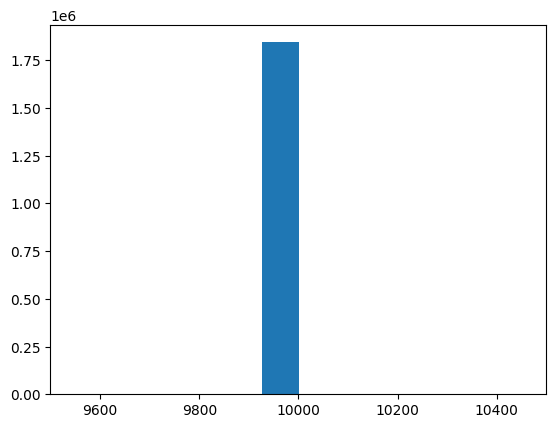

In [19]:
plt.hist(df['cycle_start_us'].diff(), bins = 100)
plt.xlim(9500,10500)
plt.show()

The controls cycle is being executed regularly, and none of the loop executions are going over time.

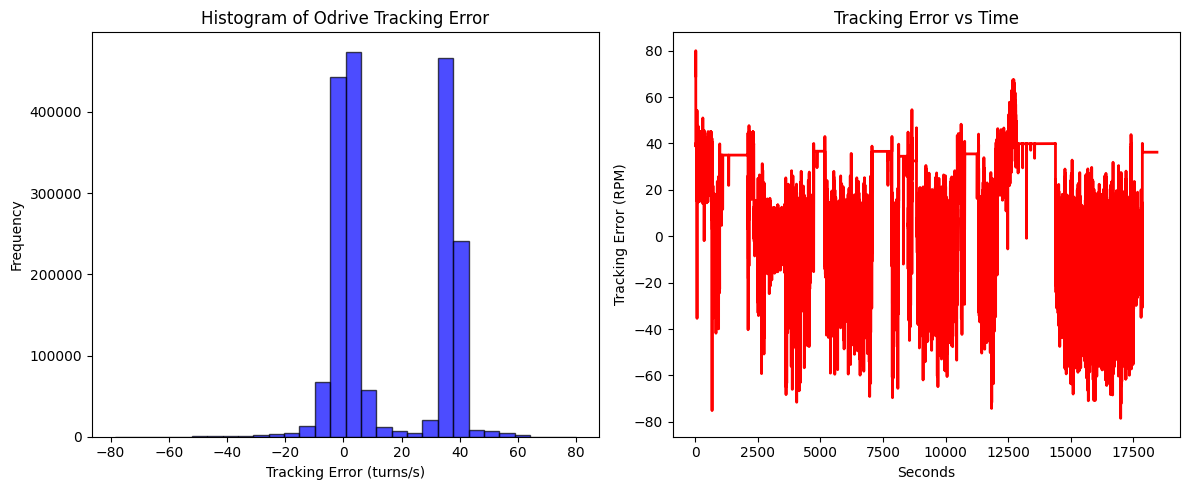

count    1.843732e+06
mean     1.546014e+01
std      1.858885e+01
min     -7.849370e+01
25%      1.668000e-01
50%      4.053100e+00
75%      3.585930e+01
max      8.000000e+01
dtype: float64

In [20]:
#Velocity Command vs Velocity Estimate
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axes[0].hist(df['velocity_estimate'] - df['velocity_command'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Odrive Tracking Error')
axes[0].set_xlabel('Tracking Error (turns/s)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['velocity_estimate'] - df['velocity_command'], color='red', linewidth=2)
axes[1].set_title('Tracking Error vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Tracking Error (RPM)')

# Adjust layout
plt.tight_layout()
plt.show()

(df['velocity_estimate'] - df['velocity_command']).describe()

Again, we have an interesting bimodal distribution here. There seem to be a lot of scenarios where the velocity estimate is larger than the velocity command. This is almost certainly due to the Odrive struggling to overcome the inertia of the actuator. In all actuality, most of the performance is centered around 0, but **we should definitely keep an eye on tuning the ODrive better**.




# Actuator Mechanical Analysis
- In this section, we explore the main mechanical characteristics of the actuator.
- Actuator Utilization
    - (histogram of actuator position when outbound limit switch is not activated)
- Limit Switch Repeatability
    - Histogram of actuator position when inbound limit switch activated. Provides insight into accuracy of actuator position estimate and our motor’s stopping ability.
    - Histogram of actuator position when outbound limit switch activated
- Actuator Torque
    - Torque applied over time. Can use electrical power from previous section as “total power”. Be careful of units, velocity estimate is in rotations/sec.


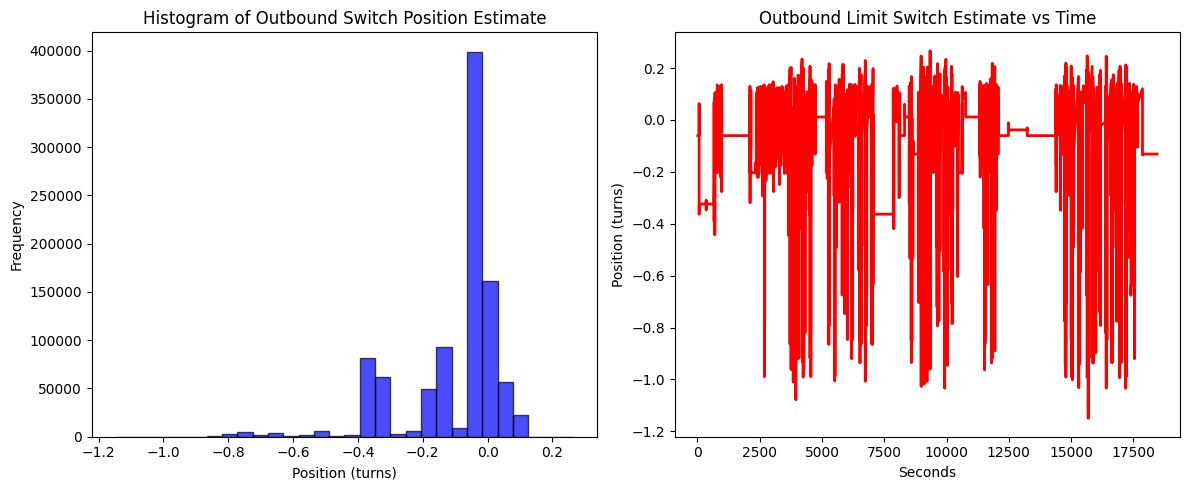

,position_estimate,seconds
count,968739.000000,968739.000000
mean,-0.110302,8210.650191
std,0.150844,5470.875389
min,-1.149800,15.171700
25%,-0.131600,2807.046700
50%,-0.060400,8216.606104
75%,-0.038400,12901.298024
max,0.266700,18452.465540


In [21]:
#Position Estimate when outbound switch engaged
clutch_pos = df.loc[(abs(df['outbound_limit_switch']) == 1), ('position_estimate','seconds')]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axes[0].hist(clutch_pos['position_estimate'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Outbound Switch Position Estimate')
axes[0].set_xlabel('Position (turns)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(clutch_pos['seconds'], clutch_pos['position_estimate'], color='red', linewidth=2)
axes[1].set_title('Outbound Limit Switch Estimate vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Position (turns)')

# Adjust layout
plt.tight_layout()
plt.show()

(clutch_pos).describe()

The error in the measurement of the position is very reasonable. From 25% to 75% of cases, we maintain within 0.1 turns of tolerance! Considering that our encoder resolution is very low, this is great!

We can expect our acutator position estimate to be 0.1 turns off on average!

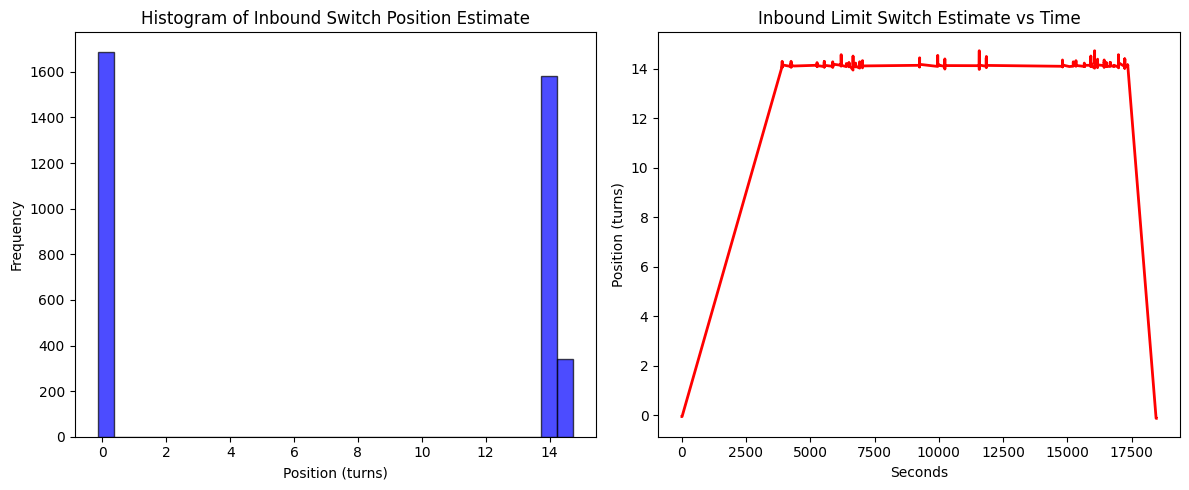

,position_estimate,seconds
count,3611.000000,3611.000000
mean,7.497446,11610.808395
std,7.132040,6937.937159
min,-0.131600,15.171700
25%,-0.131600,5547.611104
50%,14.083900,15331.043024
75%,14.160450,18443.440540
max,14.721500,18452.465540


In [54]:
#Position Estimate when inbound switch engaged
clutch_pos = df.loc[(abs(df['inbound_limit_switch']) == 1), ('position_estimate','seconds')]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axes[0].hist(clutch_pos['position_estimate'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Inbound Switch Position Estimate')
axes[0].set_xlabel('Position (turns)')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(clutch_pos['seconds'], clutch_pos['position_estimate'], color='red', linewidth=2)
axes[1].set_title('Inbound Limit Switch Estimate vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('Position (turns)')

# Adjust layout
plt.tight_layout()
plt.show()

(clutch_pos).describe()

Text(0, 0.5, 'Frequency')

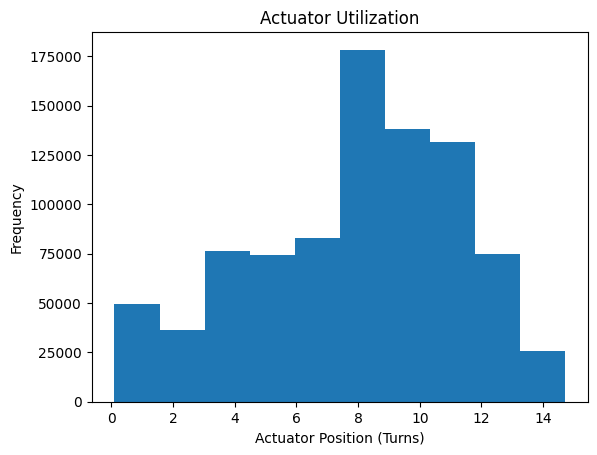

In [23]:
plt.hist(df.loc[(df['position_estimate'] > 0.1),'position_estimate'])
plt.title("Actuator Utilization")
plt.xlabel("Actuator Position (Turns)")
plt.ylabel("Frequency")

Actuator utilization indicates that we're making good use of the full range of the actuator, with most of the action happening in the middle. We want to be exactly in the middle of our system's capabilities, so this is awesome to see!

# Vehicle Dynamic Analysis

In this section we explore data analysis that’s not necessarily linked to one part of the car, but to the performance of the car as a whole.
- Transmission Ratio
- Wheel Speed Analysis
- Car Speed Analysis
- Engine RPM Analysis
    - Engine RPM over time
    - Histogram of Engine RPM



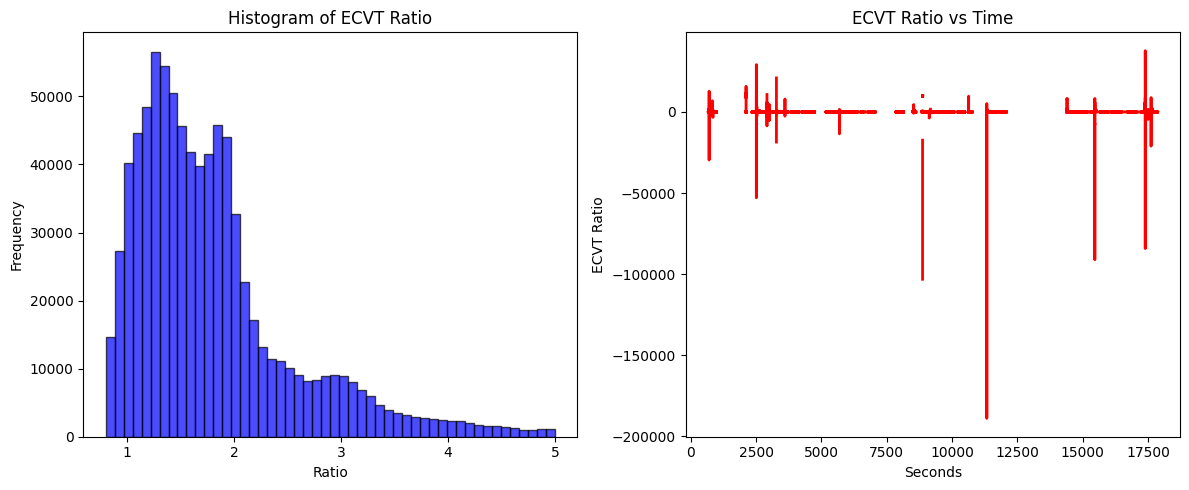

count    1.003780e+06
mean     1.539544e+01
std      3.732058e+02
min     -1.888176e+05
25%      1.331623e+00
50%      1.799497e+00
75%      2.935348e+00
max      3.775918e+04
Name: ecvt_ratio, dtype: float64

In [15]:
# Transmission Ratio (Secondary RPM / Engine RPM)
df['ecvt_ratio'] = df.loc[df['engine_rpm'] > 1800, 'filtered_engine_rpm'] / df.loc[df['engine_rpm'] > 1800, 'filtered_secondary_rpm']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram with 50 bins from 0 to 5
bins = np.linspace(0.8, 5, 51)  # 50 bins from 0 to 5
axes[0].hist(df['ecvt_ratio'], bins=bins, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Histogram of ECVT Ratio')
axes[0].set_xlabel('Ratio')
axes[0].set_ylabel('Frequency')

# Line plot
axes[1].plot(df['seconds'], df['ecvt_ratio'], color='red', linewidth=2)
axes[1].set_title('ECVT Ratio vs Time')
axes[1].set_xlabel('Seconds')
axes[1].set_ylabel('ECVT Ratio')

# Adjust layout
plt.tight_layout()
plt.show()

df['ecvt_ratio'].describe()

The ecvt ratio is defined as being secondary rpm / engine rpm.

Values near 0 in the histogram correspond to the engine spooling up, before the secondary is engaged. These values aren't of significance, as they naturally occur when the clutch is out and the engine is idling.

Our transmission ratio seems to be right-skewed from the histogram. A value lower than 1 indicates that the engine rpm is higher than the secondary rpm. While this data alone doesn't strongly indicate anything by itself, it indicates that we are biased towards a more 'torquey' controller. Considering that Penn was a relatively high speed track, it would be good to refine the controller to prioritize top speed more.

In [51]:
df['wheel_rpm'] = df['secondary_rpm'] / 7.975 #Secondary to Wheel Ratio
wheel_to_mph = (60*23*np.pi)/(5280*12)
df['car_speed_mph'] = df['wheel_rpm'] * wheel_to_mph

# Miscellaneous Analysis
- Throttle Position
- Brake Position
    - Brake vs Time
    - Histogram of Brake
- Derivative of throttle
    - d_throttle vs Time
    - Histogram of d_throttle